<h1>Practice - Text Clustering and Topic Modeling</h1>


In [1]:
 %%capture
 !pip install bertopic datasets  datamapplot

# **ArXiv Articles: Computation and Language**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
file_path = '/content/drive/MyDrive/9_cleaned_papers.csv'

try:
  df = pd.read_csv(file_path, nrows=20000)
  print("Doc file thanh cong")
  print("kich thuoc du lieu dang xu ly: ", df.shape)
  print("-"*20)
  print("DANH SACH COT TRONG FILE")
  print(df.columns.tolist())
  print("-"*20)
except FileNotFoundError:
  print("Chua tim thay file")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Doc file thanh cong
kich thuoc du lieu dang xu ly:  (20000, 2)
--------------------
DANH SACH COT TRONG FILE
['title', 'abstract']
--------------------


In [3]:
#1. Xu ly du lieu trong
# xoa cac dong ma cot 'abstract' bi trong (NAN)
df = df.dropna(subset=['abstract'])

# 2. Chuyen du lieu thanh list de dua vao mo hinh
#.astype(str) dam bao tat ca du lieu la van ban, tranh loi so hoc
abstracts = df['abstract'].astype(str).tolist()
titles = df['title'].fillna("No Title").astype(str).tolist()

# 3. Kiểm tra kết quả cuối cùng
print(f"✅ Đã chuẩn bị xong dữ liệu!")
print(f"Tổng số bài báo sẽ xử lý: {len(abstracts)}")
print("-" * 30)
print("Ví dụ bài đầu tiên:")
print(f"Tiêu đề: {titles[0]}")
print(f"Tóm tắt (100 ký tự đầu): {abstracts[0][:100]}...")

✅ Đã chuẩn bị xong dữ liệu!
Tổng số bài báo sẽ xử lý: 20000
------------------------------
Ví dụ bài đầu tiên:
Tiêu đề: Dynamic Backtracking
Tóm tắt (100 ký tự đầu): Because of their occasional need to return to shallow points in a search
tree, existing backtracking...


# **A Common Pipeline for Text Clustering**

## **1. Embedding Documents**

In [4]:
from sentence_transformers import SentenceTransformer

# su mo hinh ngon ngu loai nho da duoc huan luyen truoc
embedding_model = SentenceTransformer('thenlper/gte-small')
# chuyen doi cac abstract(tom tat)thanh day so vector, abstract la danh sach 20000 bai tom tat roi hien thi duoi dang thanh %
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

In [5]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(20000, 384)

## **2. Reducing the Dimensionality of Embeddings**

In [6]:
from umap import UMAP

# We reduce the input embeddings from 384 dimenions to 5 dimenions
# giam 384 chieu xuong 5 chieu quan trong nhat, n_components=5 -> nen du lieu xuong 5 chieu
# min_dist =0.0 la khoang cach toi thieu cua cac diem du lieu sau khi nén
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## **3. Cluster the Reduced Embeddings**

In [7]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


62

## **Inspecting the Clusters**

Manually inspect the first three documents in cluster 0:

In [8]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

Federated learning (FL) is a distributed model for deep learning that
integrates client-server architecture, edge computing, and real-time
intelligence. FL has the capability of revolutionizing machine learning (ML)
but lacks in the practicality of implementation due to technological
limitations, co... 

Federated Learning (FL) bridges the gap between collaborative machine
learning and preserving data privacy. To sustain the long-term operation of an
FL ecosystem, it is important to attract high quality data owners with
appropriate incentive schemes. As an important building block of such incentive
... 

Federated Learning, a new machine learning paradigm enhancing the use of edge
devices, is receiving a lot of attention in the pervasive community to support
the development of smart services. Nevertheless, this approach still needs to
be adapted to the specificity of the pervasive domain. In particu... 



Next, we reduce our embeddings to 2-dimensions so that we can plot them and get a rough understanding of the generated clusters.

In [9]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Static Plot

(np.float64(-0.9989154294133187),
 np.float64(11.507916893064976),
 np.float64(-0.3252759002149105),
 np.float64(11.611405985802412))

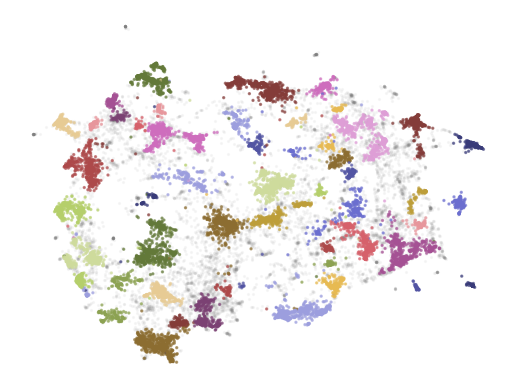

In [10]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis('off')
# plt.savefig("matplotlib.png", dpi=300)  # Uncomment to save the graph as a .png

# From Text Clustering to Topic Modeling

## **BERTopic: A Modular Topic Modeling Framework**

In [11]:
# install bertopic
!pip install bertopic datasets openai datamapplot

In [12]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-11-30 03:46:10,836 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-30 03:46:59,584 - BERTopic - Dimensionality - Completed ✓
2025-11-30 03:46:59,588 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-30 03:47:01,096 - BERTopic - Cluster - Completed ✓
2025-11-30 03:47:01,110 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-30 03:47:04,563 - BERTopic - Representation - Completed ✓


Now, let's start exploring the topics that we got by running the code above.

In [13]:
topic_model.get_topic_info()

Topic  Count                                         Name  \
0      -1   8497                             -1_the_of_and_to   
1       0    566                      0_game_games_player_the   
2       1    557                 1_ontology_ontologies_of_the   
3       2    499                    2_traffic_driving_the_and   
4       3    473            3_explanations_xai_explanation_ai   
..    ...    ...                                          ...   
57     56     57      56_neural_physics_temperature_equations   
58     57     56            57_narrative_story_stories_events   
59     58     54  58_summarization_summaries_summary_document   
60     59     53           59_patients_patient_icu_prediction   
61     60     52           60_domain_adaptation_target_source   

                                       Representation  \
0     [the, of, and, to, in, we, for, is, that, this]   
1   [game, games, player, the, of, to, playing, in...   
2   [ontology, ontologies, of, the, web, and, know...   
3   [traffic, driving, the, and, to, vehicle, vehi...   
4   [explanations, xai, explanation, ai, explainab...   
..                                                ...   
57  [neural, physics, temperature, equations, the,...   
58  [narrative, story, stories, events, narratives...   
59  [summarization, summaries, summary, document, ...   
60  [patients, patient, icu, prediction, clinical,...   
61  [domain, adaptation, target, source, uda, doma...   

                                  Representative_Docs  
0   [This paper proposes an intent-aware multi-age...  
1   [Combinations of Monte-Carlo tree search and D...  
2   [Building an ontology is not only a time-consu...  
3   [Traffic forecasting is an important prerequis...  
4   [Explainability has been a challenge in AI for...  
..                                                ...  
57  [Physics-informed neural networks allow models...  
58  [Many implicit inferences exist in text depend...  
59  [Text summarization has been a crucial problem...  
60  [Delirium is an acute confusional state that h...  
61  [Unsupervised domain adaptation (UDA) enables ...  

[62 rows x 5 columns]

Hundreds of topics were generated using the default model! To get the top 10 keywords per topic as well as their c-TF-IDF weights, we can use the `get_topic()` function:

In [14]:
topic_model.get_topic(0)

[('game', np.float64(0.049528022786223175)),
 ('games', np.float64(0.03525912041626941)),
 ('player', np.float64(0.01770179616952092)),
 ('the', np.float64(0.013870291815725203)),
 ('of', np.float64(0.013386497942712452)),
 ('to', np.float64(0.012851294105540893)),
 ('playing', np.float64(0.012622061621871364)),
 ('in', np.float64(0.012564131175894626)),
 ('players', np.float64(0.01225057983283463)),
 ('and', np.float64(0.012085077435234121))]

We can use the `find_topics()` function to search for specific topics based on a search term. Let’s search for a topic about topic modeling:

In [15]:
topic_model.find_topics("topic modeling")

([57, 21, 58, -1, 55],
 [np.float32(0.90529144),
  np.float32(0.9007354),
  np.float32(0.89804006),
  np.float32(0.89561164),
  np.float32(0.89469564)])

It returns that topic 22 has a relatively high similarity (0.95) with our search term. If we then inspect the topic, we can see that it is indeed a topic about topic modeling:

In [16]:
topic_model.get_topic(22)

[('knowledge', np.float64(0.036099313165594026)),
 ('graph', np.float64(0.027631717808551143)),
 ('embedding', np.float64(0.026599243258238654)),
 ('kg', np.float64(0.025709268633640345)),
 ('entities', np.float64(0.022894915810841535)),
 ('graphs', np.float64(0.020801434751582804)),
 ('kgs', np.float64(0.0191821113750336)),
 ('relations', np.float64(0.016556225149015134)),
 ('link', np.float64(0.016362721461912248)),
 ('entity', np.float64(0.01592911284169352))]

That seems like a topic that is, in part, characterized by the classic LDA technique. Let's see if the BERTopic paper was also assigned to topic 22:

In [17]:
# Chọn một bài báo bất kỳ trong dữ liệu của bạn (ví dụ bài ở vị trí index 100)
index_can_kiem_tra = 100

title_bai_bao = titles[index_can_kiem_tra]
topic_id = topic_model.topics_[index_can_kiem_tra]

print(f"Tên bài báo: {title_bai_bao}")
print(f"Bài báo này thuộc chủ đề số: {topic_id}")

# Xem chủ đề đó nói về cái gì
if topic_id != -1:
    print(f"Các từ khóa của chủ đề {topic_id}:")
    print(topic_model.get_topic(topic_id))
else:
    print("Bài báo này là Nhiễu (Outliers) - không thuộc chủ đề cụ thể nào.")

Tên bài báo: The Computational Complexity of Probabilistic Planning
Bài báo này thuộc chủ đề số: 6
Các từ khóa của chủ đề 6:
[('planning', np.float64(0.05905099258077652)), ('plan', np.float64(0.025800035999728868)), ('plans', np.float64(0.019003438825538326)), ('of', np.float64(0.01448767597678095)), ('domains', np.float64(0.014480218227999298)), ('planners', np.float64(0.01438591274096491)), ('the', np.float64(0.014349218045636552)), ('domain', np.float64(0.013797616813864618)), ('actions', np.float64(0.01364359091801055)), ('that', np.float64(0.013377537996483503))]


It is! We expected it might be because there are non-LDA specific words in the topic describtion such as "clustering" and "topic".

### **Visualizations**

**Visualize Documents**

In [18]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))

In [19]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

## **Representation Models**

In these examples that follow, we will update our topic representations **after** having trained our model. This allows for quick iteration. If, however, you want to use a representation model at the start of training, you will need to run it as follows:

```python
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

# Create your representation model
representation_model = KeyBERTInspired()

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(representation_model=representation_model)
```

To use the representation models, we are first going to duplicate our topic model such that easily show the differences between a model with and without representation model.

In [20]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [21]:
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):

        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

### KeyBERTInspired

In [22]:
from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0                   game | games | player | the | of   
1      1             ontology | ontologies | of | the | web   
2      2                 traffic | driving | the | and | to   
3      3  explanations | xai | explanation | ai | explai...   
4      4      logic | programs | asp | answer | programming   

                                             Updated  
0                games | game | playing | ai | chess  
1  ontology | ontologies | ontological | semantic...  
2  traffic | prediction | driving | forecasting |...  
3  explainability | explaining | explanations | e...  
4  logics | logic | reasoning | programming | sem...

### Maximal Marginal Relevance

In [23]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0                   game | games | player | the | of   
1      1             ontology | ontologies | of | the | web   
2      2                 traffic | driving | the | and | to   
3      3  explanations | xai | explanation | ai | explai...   
4      4      logic | programs | asp | answer | programming   

                                             Updated  
0                 game | player | the | playing | ai  
1             ontology | web | semantic | owl | data  
2           traffic | to | prediction | data | urban  
3  explanations | xai | ai | explainability | cou...  
4     semantics | set | program | stable | reasoning

## Text Generation



### Flan-T5

In [24]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Device set to use cuda:0
100%|██████████| 62/62 [00:15<00:00,  3.98it/s]


Topic                                           Original  \
0      0                   game | games | player | the | of   
1      1             ontology | ontologies | of | the | web   
2      2                 traffic | driving | the | and | to   
3      3  explanations | xai | explanation | ai | explai...   
4      4      logic | programs | asp | answer | programming   

                                           Updated  
0                         Science/Tech |  |  |  |   
1                         Science/Tech |  |  |  |   
2             traffic speed prediction |  |  |  |   
3  Explainable Artificial Intelligence |  |  |  |   
4                          Programming |  |  |  |

# KeyBERT

In [27]:
from bertopic.representation import KeyBERTInspired

# 1. Khởi tạo mô hình KeyBERT
# Nó sẽ dùng AI để tìm ra những từ khóa "đắt giá" nhất trong văn bản mà không cần gửi dữ liệu đi đâu cả
representation_model = KeyBERTInspired()

# 2. Cập nhật lại topic
print("Đang tinh chỉnh lại từ khóa cho các chủ đề...")
topic_model.update_topics(abstracts, representation_model=representation_model)

# 3. Xem kết quả ngay
print("✅ Xong! Dưới đây là danh sách chủ đề đã được làm sạch:")
topic_model.get_topic_info()

Đang tinh chỉnh lại từ khóa cho các chủ đề...
✅ Xong! Dưới đây là danh sách chủ đề đã được làm sạch:


Topic  Count                                               Name  \
0      -1   8497                -1_ai_algorithms_algorithm_learning   
1       0    566                            0_games_game_playing_ai   
2       1    557         1_ontology_ontologies_ontological_semantic   
3       2    499           2_traffic_prediction_driving_forecasting   
4       3    473  3_explainability_explaining_explanations_expla...   
..    ...    ...                                                ...   
57     56     57       56_physics_optimization_simulations_dynamics   
58     57     56         57_narratives_storytelling_narrative_story   
59     58     54  58_summarization_summarizing_summarisation_sum...   
60     59     53        59_predicting_predict_prediction_predictive   
61     60     52          60_unsupervised_adaptation_domains_domain   

                                       Representation  \
0   [ai, algorithms, algorithm, learning, task, re...   
1   [games, game, playing, ai, chess, starcraft, l...   
2   [ontology, ontologies, ontological, semantic, ...   
3   [traffic, prediction, driving, forecasting, co...   
4   [explainability, explaining, explanations, exp...   
..                                                ...   
57  [physics, optimization, simulations, dynamics,...   
58  [narratives, storytelling, narrative, story, s...   
59  [summarization, summarizing, summarisation, su...   
60  [predicting, predict, prediction, predictive, ...   
61  [unsupervised, adaptation, domains, domain, di...   

                                  Representative_Docs  
0   [This paper proposes an intent-aware multi-age...  
1   [Combinations of Monte-Carlo tree search and D...  
2   [Building an ontology is not only a time-consu...  
3   [Traffic forecasting is an important prerequis...  
4   [Explainability has been a challenge in AI for...  
..                                                ...  
57  [Physics-informed neural networks allow models...  
58  [Many implicit inferences exist in text depend...  
59  [Text summarization has been a crucial problem...  
60  [Delirium is an acute confusional state that h...  
61  [Unsupervised domain adaptation (UDA) enables ...  

[62 rows x 5 columns]

In [28]:
# 1. Cắt ngắn tiêu đề (Bước quan trọng nhất để không bị rối hình)
# Chỉ lấy 50 ký tự đầu tiên của tiêu đề
short_titles = [t[:50] + "..." if len(t) > 50 else t for t in titles]

# 2. Vẽ biểu đồ tương tác
fig = topic_model.visualize_documents(
    short_titles,
    reduced_embeddings=reduced_embeddings,
    hide_annotations=True, # Ẩn bớt nhãn tĩnh để hình thoáng hơn
    width=1200,
    height=750
)

# 3. Lưu thành file HTML (để mở bằng trình duyệt) và file ảnh
fig.write_html("interactive_topics.html")
fig.show() # Hiển thị ngay trên Colab


## **BONUS**: Word Cloud

Make sure to pip install `wordcloud` first in order to follow this bonus:


First, we need to make sure that each topic is described by a bit more words than just 10 as that would make for a much more interesting wordcloud.

In [29]:
topic_model.update_topics(abstracts, top_n_words=500)

2025-11-30 03:51:27,233 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Then, we can run the following code to generate the wordcloud for our topic modeling topic:

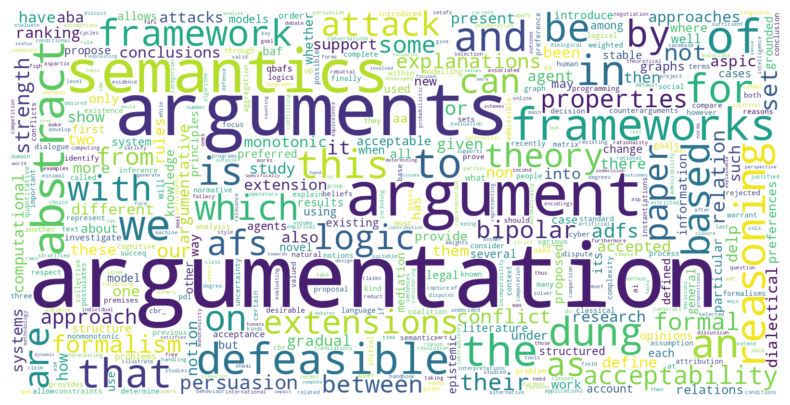

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    plt.figure(figsize=(10,5))
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000, width=1600, height=800)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=17)